Kalman Filter
（参考）https://ashikapengin.com/2021/10/20/kalman01/

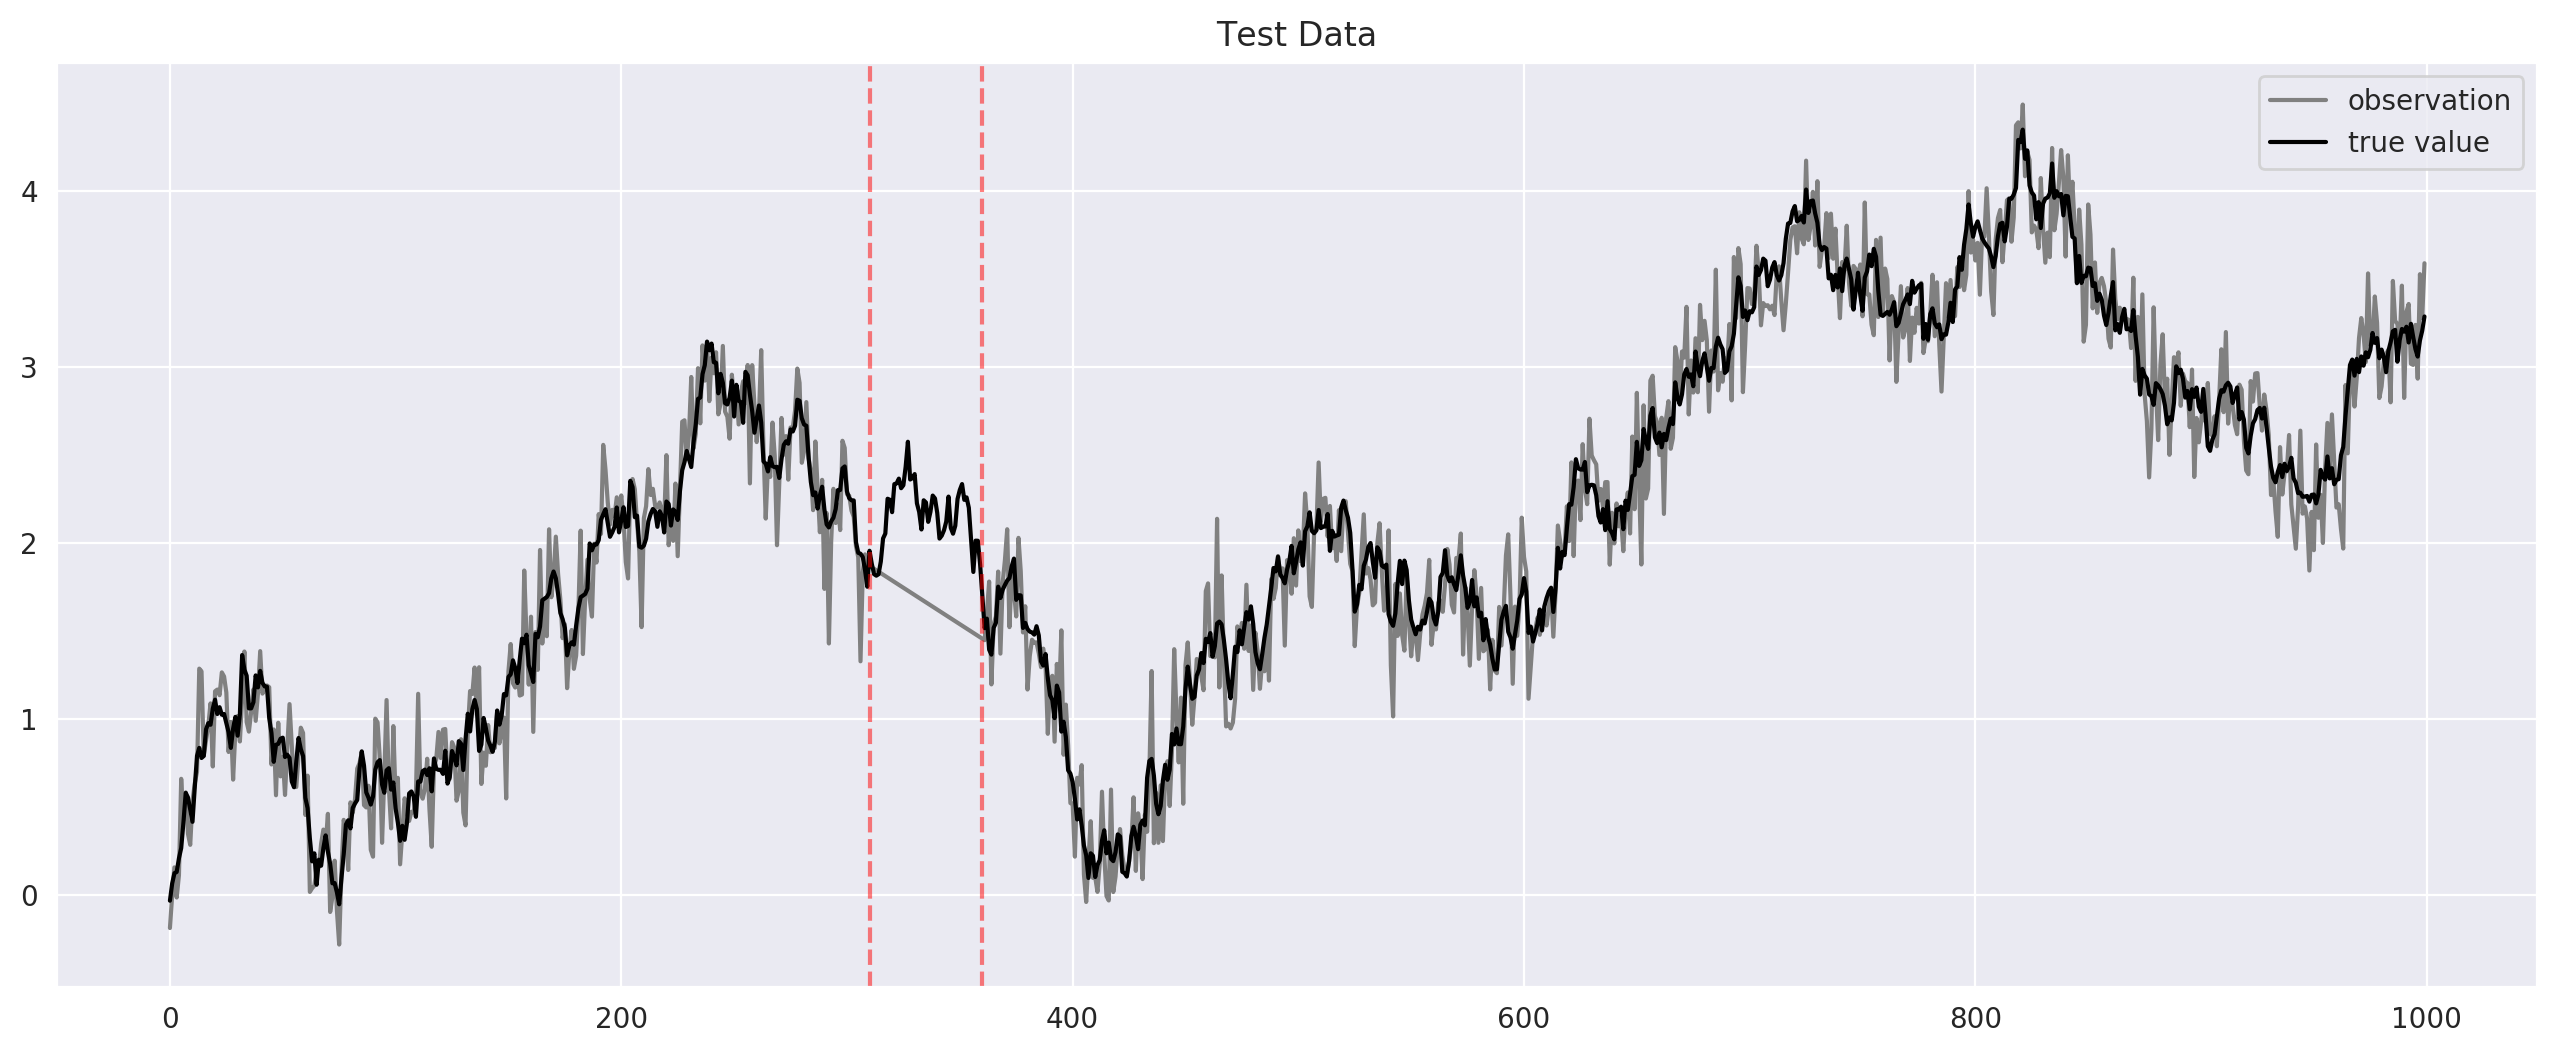

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
sns.set_style('darkgrid')

G = np.array([[1,0],[0,0]])       # システムモデルの係数行列（1次のトレンドモデル）
#G = np.array([[2,-1],[1,0]])       # システムモデルの係数行列（2次のトレンドモデル）
F = np.array([[1,0]])              # 観測モデルの係数行列
T = 1000                           #最大時間
x0 = 0                             #初期値
Tr = 0                             #尤度算出のためのトリガー(Tr=1で尤度算出用)
np.random.seed(seed=32)            #ランダムシード固定
w = np.random.normal(0, 0.1, T)    #システムノイズ(標準偏差0.1)
v = np.random.normal(0, 0.2, T)    #観測ノイズ(標準偏差0.2)
x = np.zeros(T)                    #状態変数の初期化
y = np.full(T,np.nan)              #観測値の初期化

# 状態変数と観測値の作成(t=310～360では観測値は得られなかったと仮定)
x[0] = x0 + w[0]
y[0] = x[0] + v[0]
for t in range(1, T):
    x[t] = x[t-1] + w[t]
    if t < 310 or 360 < t:
        y[t] = x[t] + v[t]

# 作成したデータの確認と保存
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
plt.title("Test Data")
sns.lineplot(x=np.arange(T), y=y, color="gray", label="observation")
sns.lineplot(x=np.arange(T), y=x, color="black", label="true value")
axes.axvline(310, color="red", linestyle="--", alpha=0.5)
axes.axvline(360, color="red", linestyle="--", alpha=0.5)
plt.show()
plt.show()
fig.savefig("data.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [2]:
def kalman_prediction(a, R, W, G=G):
    """
    Kalman prediction
    """
    a = G @ a
    R = G @ R @ G.T + W
    return a, R

def kalman_filter(m, C, y, W, V, F=F, G=G, Tr=Tr):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    m = a + K @ (y - f)
    C = R - K @ F @ R
    L = np.log(np.linalg.det(Q)) + ((y - f).T)@(np.linalg.inv(Q))@(y - f) #尤度計算のため追加
    if Tr == 1: # 尤度計算のとき
        return m, C, L.flatten()
    else: # フィルタのみ実行するとき
        return m, C

def kalman_smoothing(s, S, m, C,  W, G=G):
    """
    Kalman smoothing
    """
    # 1時点先予測分布のパラメータ計算
    a = G @ m
    R = G @ C @ G.T + W
    # 平滑化利得の計算
    A = C @ G.T @ np.linalg.pinv(R)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S

In [3]:
def calcLogLike(sigma, times): # 尤度算出用
    LLF = 0.                                  # 尤度
    m0 = np.array([0.0, 0.0])                 # 状態変数の初期値
    C0 = np.array([[1e7,0],[0,1e7]])          # 状態変数の共分散行列の初期値
    m = np.zeros((T, 2))                      # 状態変数
    C = np.zeros((T, 2, 2))                   # 状態変数の共分散行列
    sigma_exp = np.exp(sigma)                 # システムノイズと観測ノイズの分散の値 
    WL = np.array([[sigma_exp[0],0],[0,0]])   # システムノイズ
    VL = np.array([[sigma_exp[1]]])           # 観測ノイズ
    for t in range(times):
        if t == 0: #初期
            m[t], C[t], L = kalman_filter(m0, C0, y[t], W=WL , V=VL, Tr=1)
            LLF += -0.5*(1.*np.log(2.*np.pi) + L[0]) #尤度算出
        else:
            if np.isnan(y[t]): # 観測値がない場合は予測を実行
                m[t], C[t] = kalman_prediction(m[t-1], C[t-1], W=WL)
            else:
                m[t], C[t], L = kalman_filter(m[t-1], C[t-1], y[t], W=WL , V=VL, Tr=1)
                LLF += -0.5*(1.*np.log(2.*np.pi) + L[0]) #尤度算出
    return -LLF

# L-BFGS-B
bounds = ((-40.,1.), (-20.,1.)) #変数の範囲
times = 500                     #尤度算出に時刻いつまでを使うか
result = scipy.optimize.minimize(calcLogLike, x0=[-10.0, -10.0], method="L-BFGS-B", bounds = bounds, args=(times,))
W1_predict = np.exp(result.x[0]) # システムノイズの分散
V1_predict = np.exp(result.x[1]) # 観測ノイズの分散
result_fun = calcLogLike(sigma=[result.x[0],result.x[1]],times = times)
print('W1_predict = {0:.6g}, V1_predict = {1:.6g}, likelihood = {2:.6g}'.format(W1_predict, V1_predict, -result_fun))

# 差分進化
# bounds = ((-40.,1.), (-20.,1.)) #変数の範囲
# time = 500                     #尤度算出に時刻いつまでを使うか
# result = scipy.optimize.differential_evolution(calcLogLike, bounds = bounds, args=(times,))
# W1_predict = np.exp(result.x[0]) # システムノイズの分散
# V1_predict = np.exp(result.x[1]) # 観測ノイズの分散
# result_fun = calcLogLike(sigma=[result.x[0],result.x[1]],times = times)
# print('W1_predict = {0:.6g}, V1_predict = {1:.6g}, likelihood = {2:.6g}'.format(W1_predict, V1_predict, -result_fun))

W1_predict = 0.0114134, V1_predict = 0.0408188, likelihood = -46.9124


In [4]:
# 初期状態のフィルタリング分布のパラメータ
m0 = np.array([0.0, 0.0])             # 状態変数の初期値
C0 = np.array([[1e7,0],[0,1e7]])      # 状態変数の共分散行列の初期値
WL = np.array([[W1_predict,0],[0,0]]) # システムノイズ
VL = np.array([[V1_predict]])         # 観測ノイズ
m = np.zeros((T, 2))                  # 状態変数
C = np.zeros((T, 2, 2))               # 状態変数の共分散行列
s = np.zeros((T, 2))                  # 状態変数(カルマン平滑化用)
S = np.zeros((T, 2, 2))               # 状態変数の共分散行列(カルマン平滑化用)

# カルマンフィルター＋カルマン予測 内容尤度算出と同じ
for t in range(T):
    if t == 0:
        m[t], C[t] = kalman_filter(m0, C0, y[t], W=WL , V=VL)
    else:
        if np.isnan(y[t]):
            m[t], C[t] = kalman_prediction(m[t-1], C[t-1], W=WL)
        else:
            m[t], C[t] = kalman_filter(m[t-1], C[t-1], y[t], W=WL , V=VL)

# カルマン平滑化
for t in range(T):
    t = T - t - 1
    if t == T - 1:
        s[t] = m[t]
        S[t] = C[t]
    else:
        s[t], S[t] = kalman_smoothing(s[t+1], S[t+1], m[t], C[t], W=WL)

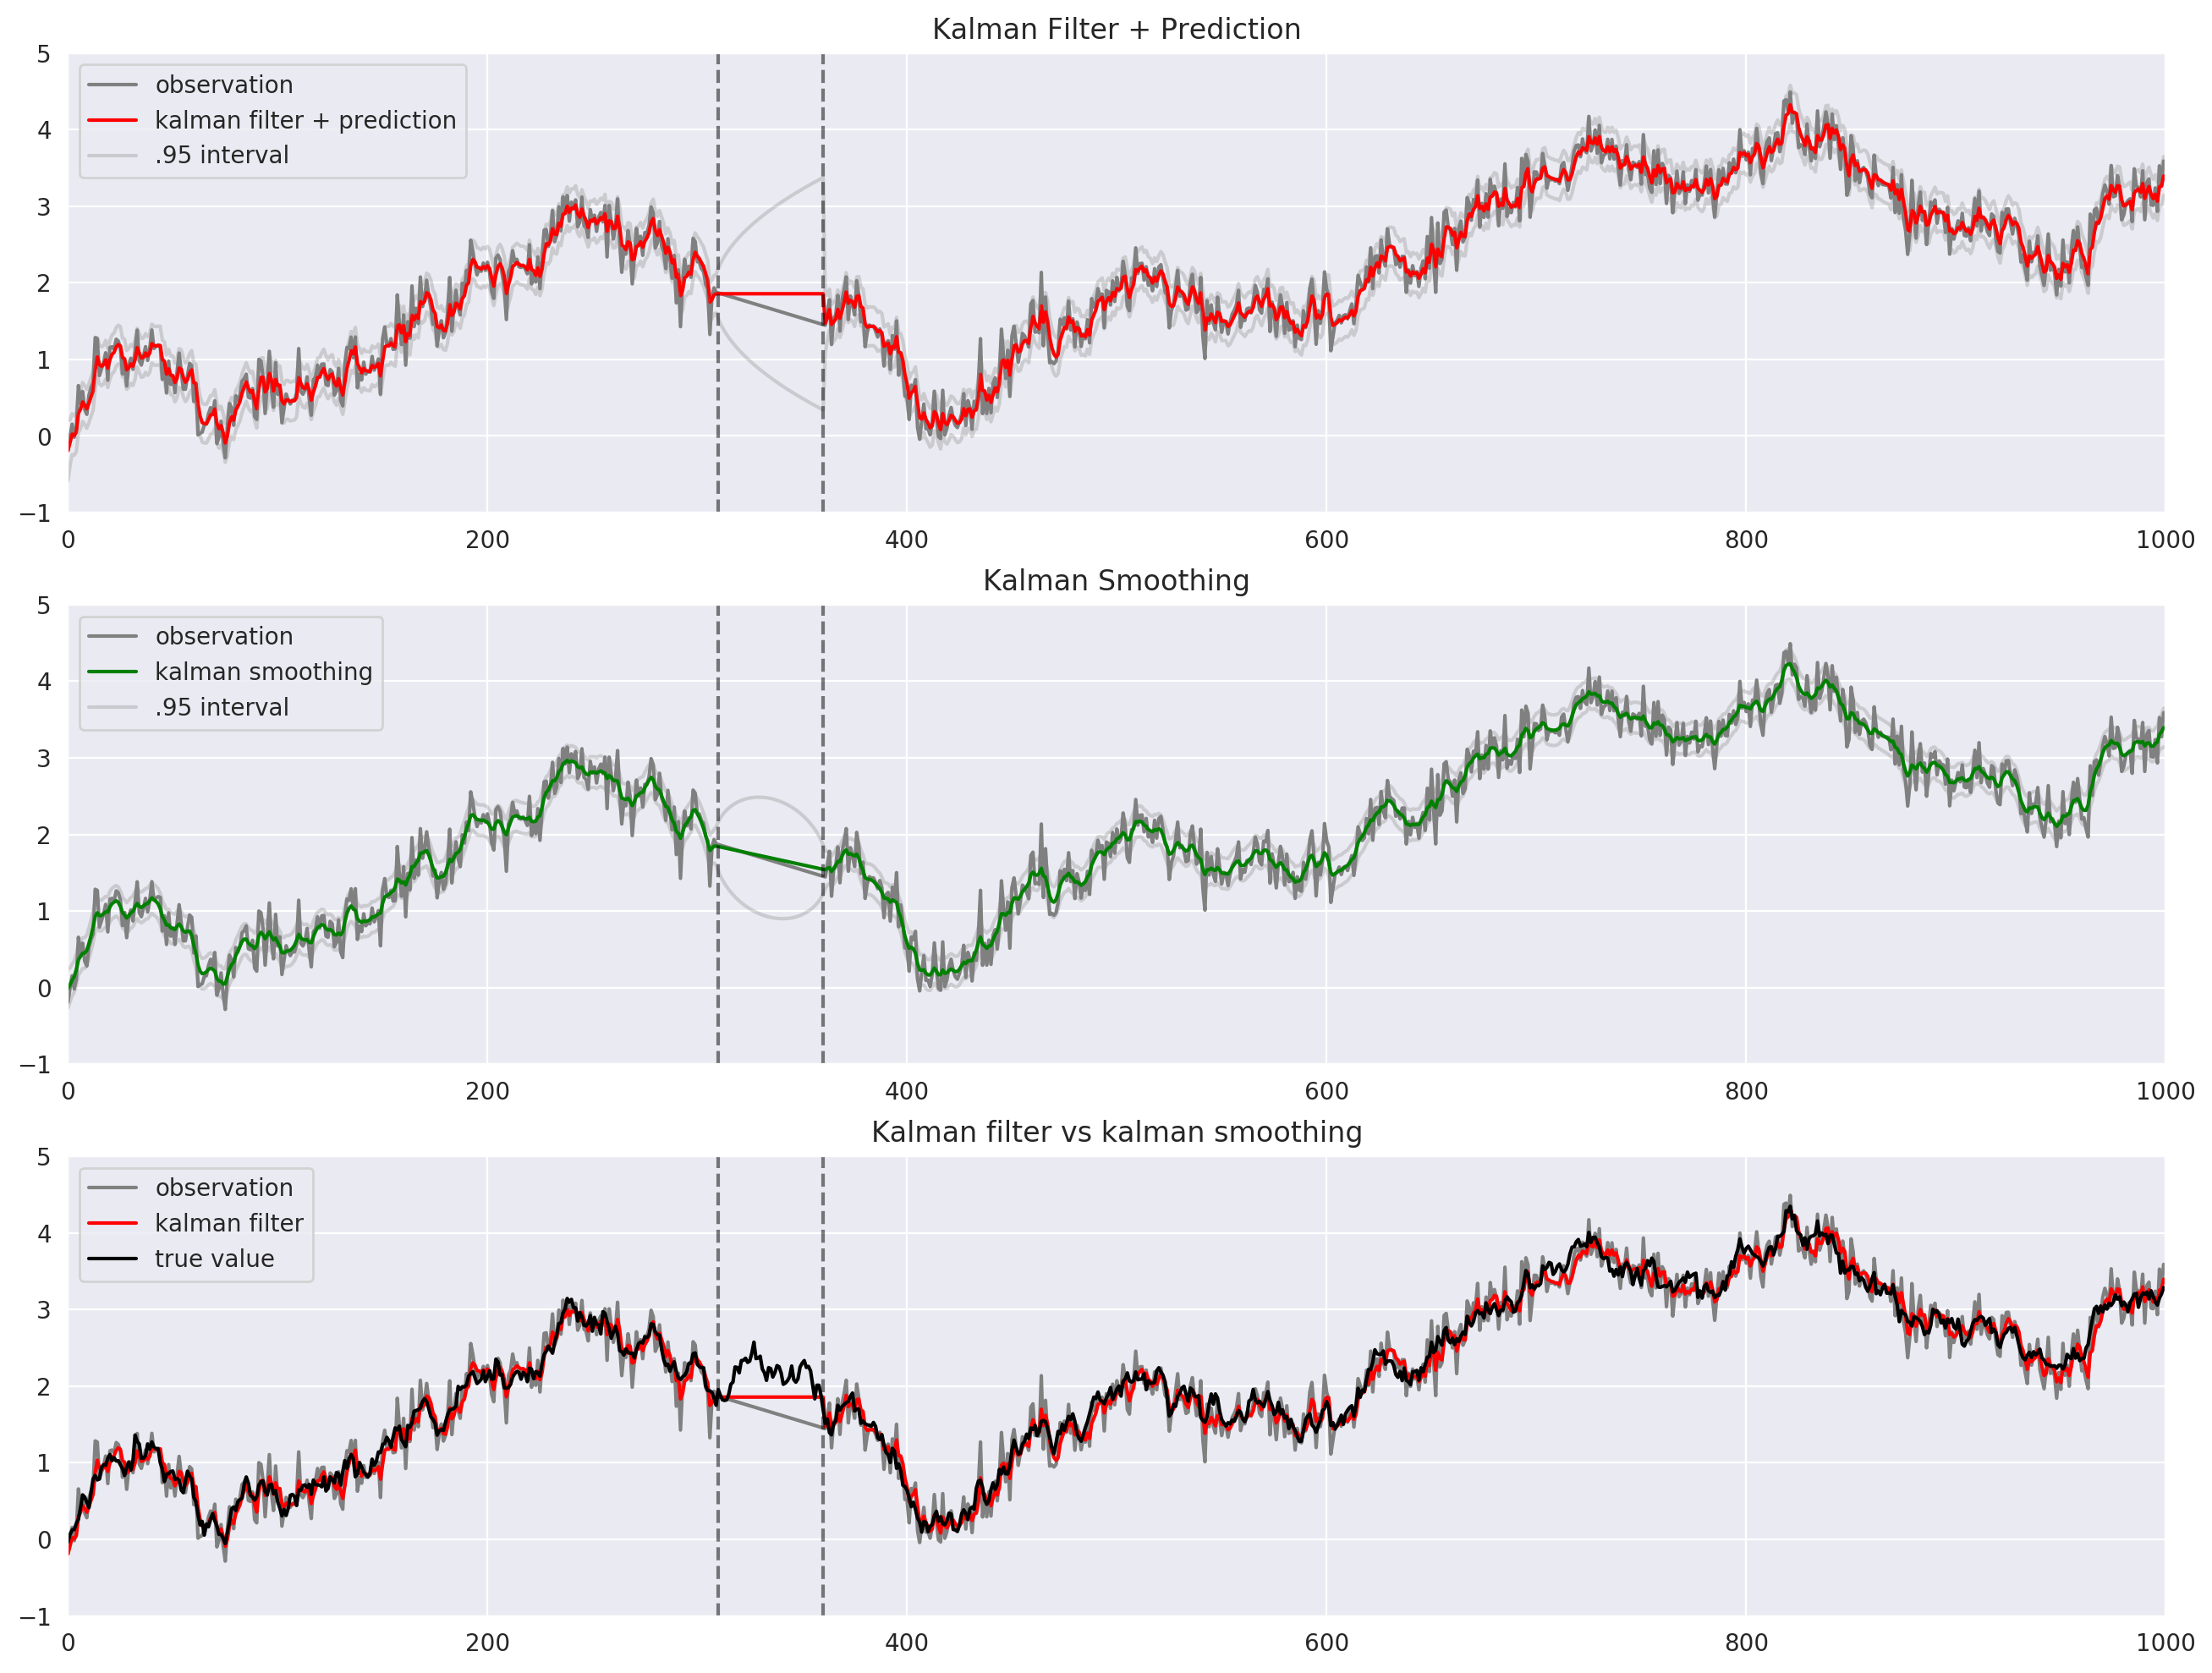

In [5]:
upper = 5 # y軸の上限
lower = -1 # y軸の下限
x_min = 0 # x軸の下限
x_max = 1000 # x軸の上限

legend_loc = "upper left"

fig, axes = plt.subplots(nrows=3, figsize=(16, 12))
sns.lineplot(x=np.arange(T), y=y, color="gray", ax=axes[0], label="observation")
sns.lineplot(x=np.arange(T), y=m[:,0].flatten(), color="red", ax=axes[0], label="kalman filter + prediction")
axes[0].plot(np.arange(T), (m[:,0] - 1.96 * C[:,0,0]**(1/2)).flatten(), alpha=0.3, color='gray', label=".95 interval")
axes[0].plot(np.arange(T), (m[:,0] + 1.96 * C[:,0,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[0].axvline(310, color="black", linestyle="--", alpha=0.5)
axes[0].axvline(360, color="black", linestyle="--", alpha=0.5)
axes[0].set_ylim(lower, upper)
axes[0].set_xlim(x_min, x_max)
axes[0].legend(loc=legend_loc)
axes[0].set_title("Kalman Filter + Prediction")

sns.lineplot(x=np.arange(T), y=y, color="gray", ax=axes[1], label="observation")
sns.lineplot(x=np.arange(T), y=s[:,0].flatten(), color="green", ax=axes[1], label="kalman smoothing")
axes[1].plot(np.arange(T), (s[:,0] - 1.96 * S[:,0,0]**(1/2)).flatten(), alpha=0.3, color='gray', label=".95 interval")
axes[1].plot(np.arange(T), (s[:,0] + 1.96 * S[:,0,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[1].axvline(310, color="black", linestyle="--", alpha=0.5)
axes[1].axvline(360, color="black", linestyle="--", alpha=0.5)
axes[1].set_ylim(lower, upper)
axes[1].set_xlim(x_min, x_max)
axes[1].legend(loc=legend_loc)
axes[1].set_title("Kalman Smoothing")

# sns.lineplot(np.arange(T+K), x, ax=axes[2], label="true state")
sns.lineplot(x=np.arange(T), y=y, color="gray", ax=axes[2], label="observation")
sns.lineplot(x=np.arange(T), y=m[:,0].flatten(), color="red", ax=axes[2], label="kalman filter")
sns.lineplot(x=np.arange(T), y=x.flatten(), color="black", ax=axes[2], label="true value")
axes[2].axvline(310, color="black", linestyle="--", alpha=0.5)
axes[2].axvline(360, color="black", linestyle="--", alpha=0.5)
axes[2].set_ylim(lower, upper)
axes[2].set_xlim(x_min, x_max)
axes[2].legend(loc=legend_loc)
axes[2].set_title("Kalman filter vs kalman smoothing")
plt.show()
fig.savefig("result.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)

# 出力関係
df = pd.DataFrame(np.concatenate([x.reshape(T,1), y.reshape(T,1), m[:,0].reshape(T,1), s[:,0].reshape(T,1)], 1))
df.columns=["true value", "obsevation", "kalman filter", "kalman smoothing"]
df.to_csv("output.csv")